# Optical flow
## Lukas - Kanade

In [3]:
import matplotlib.pyplot as plt # 3.1.0
import numpy as np              # 1.16.4
from matplotlib import cm
from PIL import Image
import cv2
import sys
import os
from skimage import io          # 0.15.0

import display
import read_data

sys.path.append('./noiseless_data/')


In [4]:
def calcTrackErrors(p0,p1,dist):
    length=(p0-p1)*(p0-p1)
    length=np.sqrt(length[:,0,0]+length[:,0,1])
    
    #Calculate signal-to-noise ratio
    snr = dist/length
    
    return length,snr


In [3]:
PATH = r"./data/volcano_des/"
MASTER_MAT = 'master.mat'
KEY1 = 'master_des_crp'
SLAVE_MAT = 'slave.mat'
KEY2 = 'slave_des_crp'

In [4]:
is_master = os.path.exists(PATH+'master.tiff')
is_slave = os.path.exists(PATH+'slave.tiff')
if (is_master == False) and (is_slave == False):
    [mstr_amp, slv_amp] = read_data.read_img_nocrop_opt(MASTER_MAT, KEY1, SLAVE_MAT, KEY2, PATH)    


my_img_master = io.imread(PATH + 'master.tiff').astype(np.float32)
my_img_slave = io.imread(PATH + 'slave.tiff').astype(np.float32)

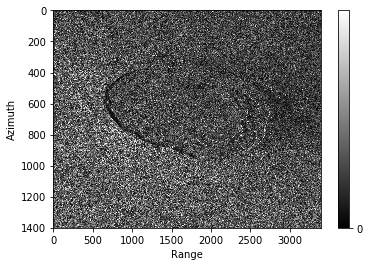

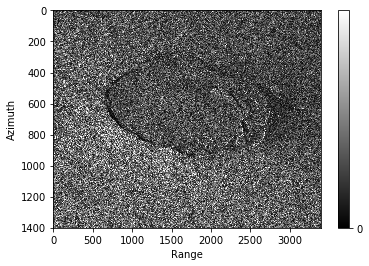

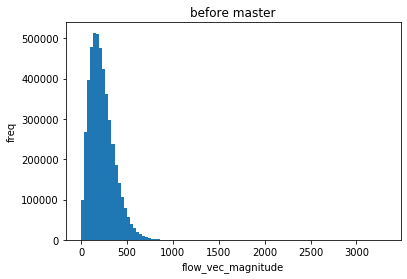

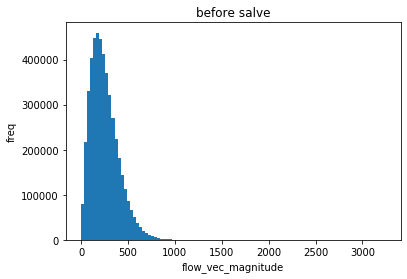

In [5]:
display.display(my_img_master, my_img_slave, vmin=0, vmax=700)
display.plot_hist(np.ravel(my_img_master), title="before master")
display.plot_hist(np.ravel(my_img_slave), title="before salve")

In [6]:
my_img_master = 255*(my_img_master-np.min(my_img_master))/(np.max(my_img_master) - np.min(my_img_master))#500)#
my_img_slave = 255*(my_img_slave-np.min(my_img_slave))/(np.max(my_img_slave) -np.min(my_img_slave)) # 500)#

In [13]:
point_thre = 120000
dist_thre = 8
corners = cv2.goodFeaturesToTrack(my_img_master, point_thre, 0.01,10)

In [14]:
win_size = (105, 105)
max_level = 1
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)

# Performm LK-tracking
lk_params = {"winSize": win_size,
            "maxLevel": max_level,
            "criteria": criteria}
kp2, st, err = cv2.calcOpticalFlowPyrLK(my_img_master.astype(np.uint8),
                                       my_img_slave.astype(np.uint8),
                                       corners, 
                                       None,
                                       **lk_params)
kp3, st, err = cv2.calcOpticalFlowPyrLK(my_img_slave.astype(np.uint8),
                                       my_img_master.astype(np.uint8),
                                       kp2,
                                       None,
                                       **lk_params)
dist = (corners-kp3)*(corners-kp3)
print(dist.shape)
dist=np.sqrt(dist[:,0,0]+dist[:,0,1])            
tracked = len(dist)
good = dist < 1

corners = corners.reshape(-1,2)
kp2 = kp2.reshape(-1,2)
kp3 = kp3.reshape(-1,2)

robust_mp = kp2 - kp3
robust_mp_mag = np.linalg.norm(robust_mp, axis=1)
good = robust_mp_mag < dist_thre
corners = corners[good]
kp2=kp2[good]
kp3=kp3[good]
dist = dist[good]
flow_vec= (kp2-kp3)
final_flow_mag = np.linalg.norm(flow_vec, axis=1)
print('Mean of flow vector magnitude: ', np.mean(final_flow_mag))
print('std of flow vector magnitude: ', np.std(final_flow_mag))

(25308, 1, 2)
Mean of flow vector magnitude:  0.3025951
std of flow vector magnitude:  0.4046229


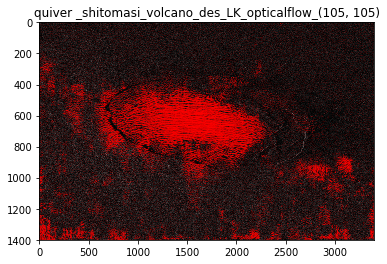

signal to noise ratio:  0.36378258


In [15]:
display.draw_fv_4test(my_img_slave, corners, flow_vec,
                    'quiver '+
                      '_shitomasi_'+ PATH[7:-1]+'_LK_opticalflow_'+ np.str(lk_params['winSize']))
corners= corners.reshape(-1,1,2)
kp2 = kp2.reshape(-1,1,2)
length,snr=calcTrackErrors(corners,kp2,dist)
print("signal to noise ratio: ",np.mean(snr))

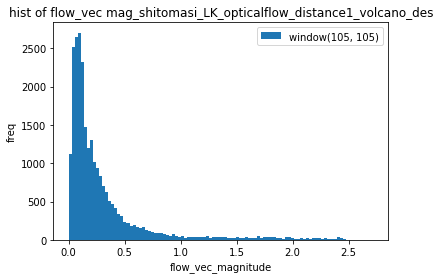

In [16]:
display.plot_hist(final_flow_mag,
                 'hist of flow_vec mag_shitomasi_LK_opticalflow_distance1_'+
                  PATH[7:-1], labels="window"+str(win_size))

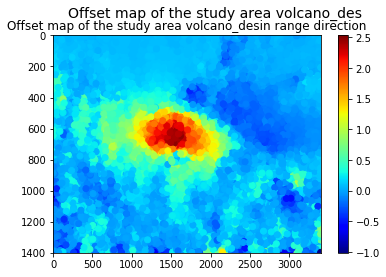

In [17]:
#     save flow vectors and coordinates in text file or csv  
corners = corners.reshape(-1,2)
#    fname= "./fv_save/lukas_subpix_winsize_"+str(win_size)+"_"+PATH[2:-1]+"_pthre_"+ str(point_thre)+"_dthre_"+ np.str(dist_thre)+".csv"
#    np.savetxt(fname, np.transpose((corners[:,0],corners[:,1], flow_vec[:,0],flow_vec[:,1])), delimiter=",")
    
display.scatter_flow_vec(my_img_master, flow_vec[:,0], corners, path=PATH[7:-1], dirc='range')


In [17]:
PATH = r"./data/volcano_des_goldstein/"
MASTER_MAT = 'master.mat'
KEY1 = 'master_out'
SLAVE_MAT = 'slave.mat'
KEY2 = 'slave_out'

In [18]:
is_master = os.path.exists(PATH+'master.tiff')
is_slave = os.path.exists(PATH+'slave.tiff')
if (is_master == False) and (is_slave == False):
    [mstr_amp, slv_amp] = read_data.read_img_nocrop_opt(MASTER_MAT, KEY1, SLAVE_MAT, KEY2, PATH)    


my_img_master = io.imread(PATH + 'master.tiff').astype(np.float32)
my_img_slave = io.imread(PATH + 'slave.tiff').astype(np.float32)

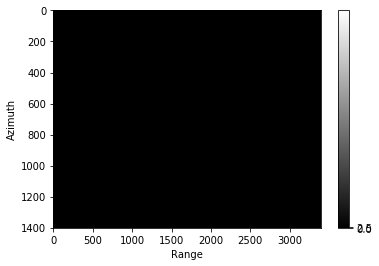

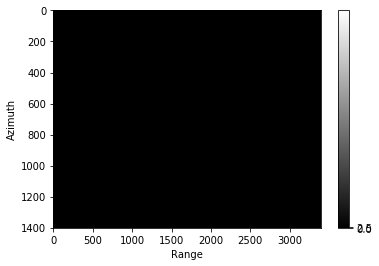

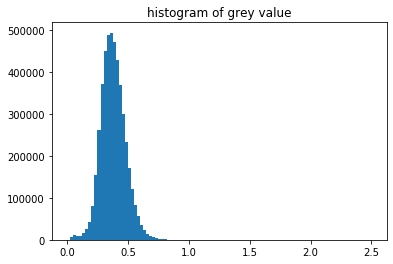

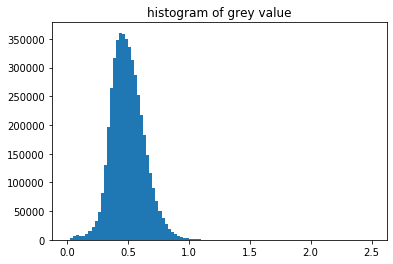

In [21]:
display.display(my_img_master, my_img_slave, vmin=0, vmax=700)
plt.hist(np.ravel(my_img_master), bins = 100)
plt.title("histogram of grey value")
plt.show()
plt.hist(np.ravel(my_img_slave), bins=100)
plt.title("histogram of grey value")
plt.show()

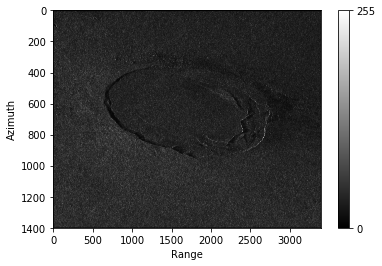

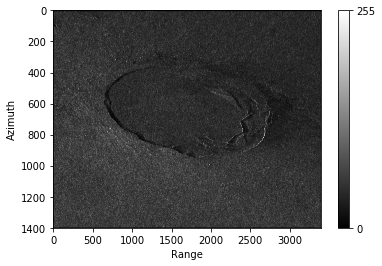

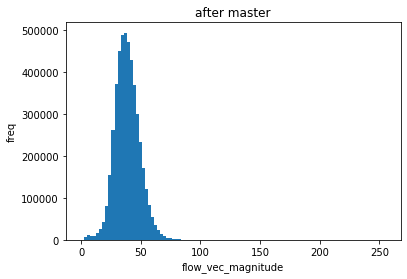

In [7]:
my_img_master = 255*(my_img_master-np.min(my_img_master))/(np.max(my_img_master) - np.min(my_img_master))#500)#
my_img_slave = 255*(my_img_slave-np.min(my_img_slave))/(np.max(my_img_slave) -np.min(my_img_slave)) # 500)#
display.display(my_img_master,my_img_slave )
display.plot_hist(np.ravel(my_img_master), title = "after master")


In [8]:
point_thre = 12000
dist_thre = 8
corners = cv2.goodFeaturesToTrack(my_img_master, point_thre, 0.01,10) 

In [9]:
win_size = (105, 105)
max_level = 1
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)

# Performm LK-tracking
lk_params = {"winSize": win_size,
            "maxLevel": max_level,
            "criteria": criteria}
kp2, st, err = cv2.calcOpticalFlowPyrLK(my_img_master.astype(np.uint8),
                                       my_img_slave.astype(np.uint8),
                                       corners, 
                                       None,
                                       **lk_params)
kp3, st, err = cv2.calcOpticalFlowPyrLK(my_img_slave.astype(np.uint8),
                                       my_img_master.astype(np.uint8),
                                       kp2,
                                       None,
                                       **lk_params)
dist = (corners-kp3)*(corners-kp3)
print(dist.shape)
dist=np.sqrt(dist[:,0,0]+dist[:,0,1])            
tracked = len(dist)
good = dist < 1

corners = corners.reshape(-1,2)
kp2 = kp2.reshape(-1,2)
kp3 = kp3.reshape(-1,2)

robust_mp = kp2 - kp3
robust_mp_mag = np.linalg.norm(robust_mp, axis=1)
good = robust_mp_mag < dist_thre
corners = corners[good]
kp2=kp2[good]
kp3=kp3[good]
dist = dist[good]
flow_vec= (kp2-kp3)
final_flow_mag = np.linalg.norm(flow_vec, axis=1)
print('Mean of flow vector magnitude: ', np.mean(final_flow_mag))
print('std of flow vector magnitude: ', np.std(final_flow_mag))

(12000, 1, 2)
Mean of flow vector magnitude:  1.0711529
std of flow vector magnitude:  0.9845292


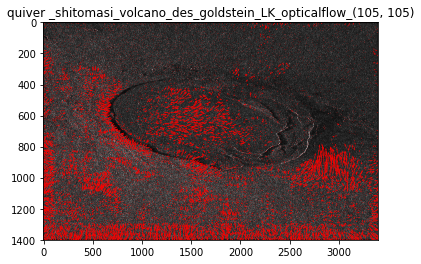

signal to noise ratio:  1.1229277


In [10]:
display.draw_fv_4test(my_img_slave, corners, flow_vec,
                    'quiver '+
                      '_shitomasi_'+ PATH[7:-1]+'_LK_opticalflow_'+ np.str(lk_params['winSize']))
corners= corners.reshape(-1,1,2)
kp2 = kp2.reshape(-1,1,2)
length,snr=calcTrackErrors(corners,kp2,dist)
print("signal to noise ratio: ",np.mean(snr))

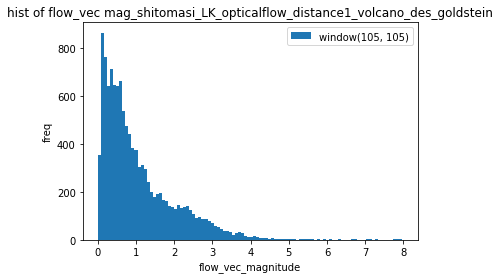

In [11]:
display.plot_hist(final_flow_mag,
                 'hist of flow_vec mag_shitomasi_LK_opticalflow_distance1_'+
                  PATH[7:-1], labels="window"+str(win_size))

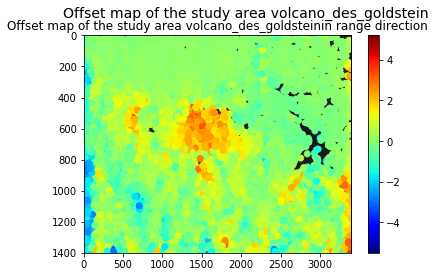

In [12]:
#     save flow vectors and coordinates in text file or csv  
corners = corners.reshape(-1,2)
#    fname= "./fv_save/lukas_subpix_winsize_"+str(win_size)+"_"+PATH[2:-1]+"_pthre_"+ str(point_thre)+"_dthre_"+ np.str(dist_thre)+".csv"
#    np.savetxt(fname, np.transpose((corners[:,0],corners[:,1], flow_vec[:,0],flow_vec[:,1])), delimiter=",")
    
display.scatter_flow_vec(my_img_master, flow_vec[:,0], corners, path=PATH[7:-1], dirc='range')
